In [1]:
using HDF5, Statistics, Images, ImageView

In [2]:
using Knet

# Data

The preprocessed data is stored in .h5 files. Images are cropped from the original size of 1024x1024 to 256x256.

In [ ]:
# load training data
file_path = "/mnt/jk489/Kathi/Julia/cropped_data_0_3000.h5" # not provided
train_data = h5read(file_path, "data");
X_train = convert(KnetArray, reshape(train_data[:,:,1:100,2], 256,256,1,100));
Y_train = convert(KnetArray, reshape(train_data[:,:,1:100,1], 256,256,1,100));

In [ ]:
# load testing data
file_path = "./cropped_data_3000_6000.h5" # not provided
test_data = h5read(file_path, "data");
X_test = convert(KnetArray, reshape(test_data[:,:,1:10,2], 256,256,1,10));
Y_test = convert(KnetArray, reshape(test_data[:,:,1:10,1], 256,256,1,10));

# Model

We use a UNet (as described by Ronneberger et al) to segment cell bodies (foreground). Input is a 256x256x1 grey scale image, output a 256x256x1 mask of the cell bodies.

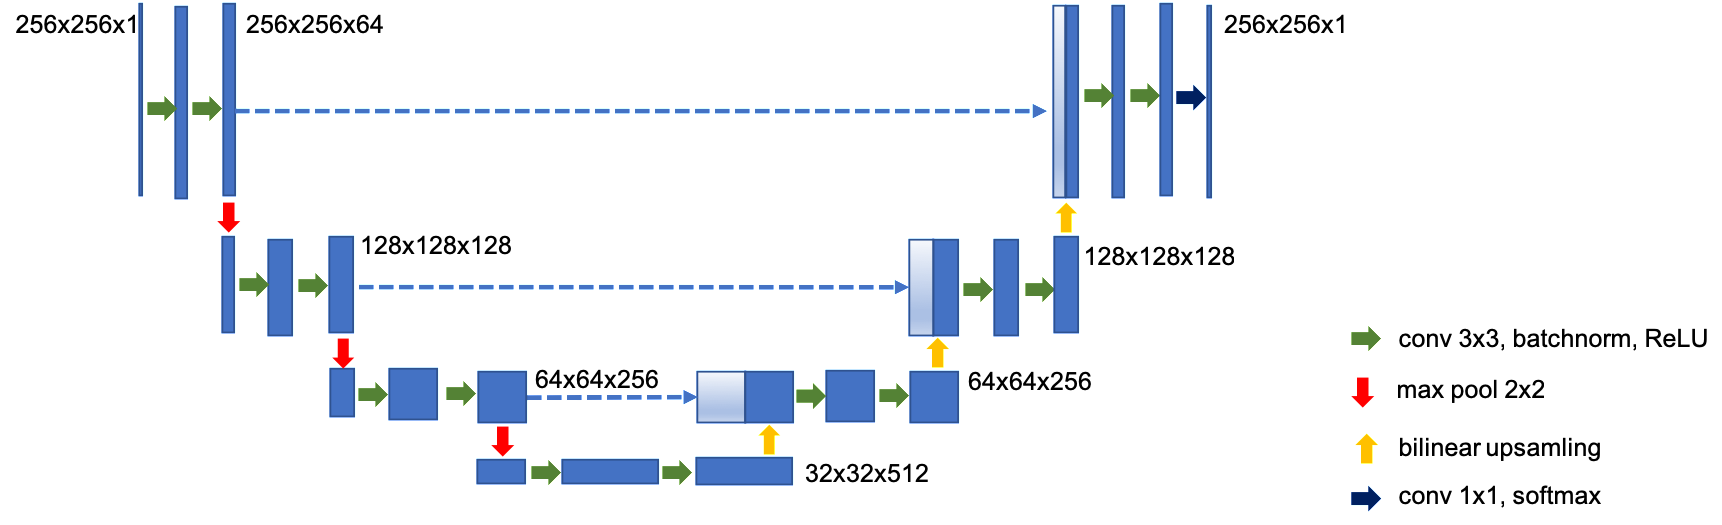

In [7]:
architecture  = load("./images_for_notebook/UNet_architecture.png")

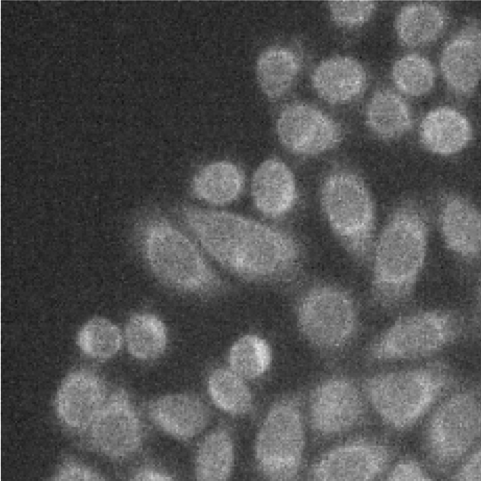

In [6]:
input = load("./images_for_notebook/example_input.png")

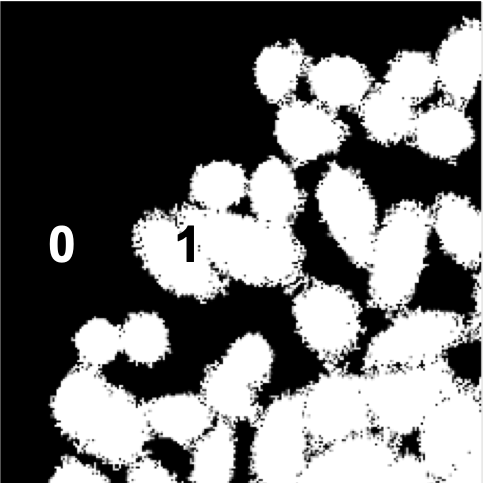

In [5]:
mask = load("./images_for_notebook/example_mask.png")

foreground = 1; background = 0

## Helper

In [ ]:
function flatten(array)
    size_array = size(array)
    length_flattened = 1
    for dim = 1:ndims(array)
        length_flattened = length_flattened * size_array[dim]
    end
    return flattened = reshape(array,length_flattened)
end

In [ ]:
function cat3d(arr1, arr2)
    R = size(arr1)[1]
    C = size(arr1)[2]
    Ch = size(arr1)[3]+size(arr2)[3]
    S = size(arr1)[4]
    
    arr1 = flatten(permutedims(arr1, [1,2,4,3]))
    arr2 = flatten(permutedims(arr2, [1,2,4,3]))
    out = reshape(cat1d(arr1,arr2),R,C,S,Ch)
    out = permutedims(out,[1,2,4,3])
    
    return out
end

## UNet

In [ ]:
function conv_layer_encoder(w, bn_params, x)
    out = conv4(w[1], x, padding=1).+ w[2]
    out = batchnorm(out, bn_moments[1], w[3])
    conv_1 = relu.(out)
    
    out = conv4(w[4], conv_1, padding=1) .+ w[5]
    out = batchnorm(out, bn_moments[2], w[6])
    out = relu.(out)
    pooled = pool(out)
    
    return conv_1, pooled
end

In [ ]:
function conv_layer_encoder(w, bn_params, x, )
    out = conv4(w[1], x, padding=1).+ w[2]
    out = batchnorm(out, bn_moments[1], w[3])
    conv_1 = relu.(out)
    
    out = conv4(w[4], conv_1, padding=1) .+ w[5]
    out = batchnorm(out, bn_moments[2], w[6])
    out = relu.(out)
    pooled = pool(out)
    
    return conv_1, pooled
end

In [ ]:
function conv_layer_decoder(w, bn_moments, x_cat, x)
    number_of_channels = size(x)[3]
    upsampling_kernel = convert(KnetArray, bilinear(Float64,2,2,number_of_channels,number_of_channels))
    out = deconv4(upsampling_kernel, x, padding = 1,stride = 2) 
    out = cat3d(out, x_cat)
    
    out = conv4(w[1], out, padding = 1) .+ w[2]
    out = batchnorm(out, bn_moments[1], w[3])
    out = relu.(out)
    
    out = conv4(w[4], out, padding = 1) .+ w[5]
    out = batchnorm(out, bn_moments[2], w[6])
    out = relu.(out)
    
    return out
end

In [ ]:
function bottleneck(w, bn_moments, x)
    out = conv4(w[1], x, padding = 1) .+ w[2]
    out = batchnorm(out, bn_moments[1], w[3])
    out = relu.(out)
    
    out = conv4(w[4], out, padding = 1) .+ w[5]
    out = batchnorm(out, bn_moments[2], w[6])
    out = relu.(out)
    
    return out
end

In [ ]:
function output_layer(w, x)
    out = sigm.(conv4(w[1], x, padding = 1).+ w[2])
    
    return out
end

In [ ]:
function predict(x_in, w, bn_moments)
    conv_1, out = conv_layer_encoder(w[1:6], bn_moments[1:2], x_in);
    # layer 2
    conv_2, out = conv_layer_encoder(w[7:12], bn_moments[3:4], out);
    #layer 3
    conv_3, out = conv_layer_encoder(w[13:18], bn_moments[5:6], out);
    # layer 4 = bottleneck
    out = bottleneck(w[19:24], bn_moments[7:8], out);
    # layer 5
    out = conv_layer_decoder(w[25:30], bn_moments[9:10], conv_3, out);
    # layer 6
    out = conv_layer_decoder(w[31:36], bn_moments[11:12], conv_2, out);
    # layer 7
    out = conv_layer_decoder(w[37:42], bn_moments[13:14], conv_1, out);
    out = output_layer(w[43:44], out)
    
    return out
end

## Initialize weights

In [ ]:
function init_model(n_input_channels=1, n_output_channels=1, depth=4, max_channels=512, kernel_size=3)
    w = Any[]
    bn_moments = Any[bnmoments() for i = 1:14]
    # 1st layer
    # convolution
    push!(w,xavier(Float64,kernel_size,kernel_size,n_input_channels,Int64(max_channels/(2^(depth-1)))));
    # bias
    push!(w,zeros(Float64,1,1,Int64(max_channels/(2^(depth-1))),1));
    # batchnorm params
    push!(w, bnparams(Float64,Int64(max_channels/(2^(depth-1)))));
    # convolution
    push!(w,xavier(Float64,kernel_size,kernel_size,Int64(max_channels/(2^(depth-1))),Int64(max_channels/(2^(depth-1)))));
    # bias
    push!(w,zeros(Float64,1,1,Int64(max_channels/(2^(depth-1))),1));
    # batchnorm params
    push!(w, bnparams(Float64,Int64(max_channels/(2^(depth-1)))));
    
    # encoding arm: 2nd up to and including bottleneck
    for layer=2:depth
       push!(w,xavier(Float64,kernel_size,kernel_size,Int64(max_channels/(2^(depth-layer+1))),Int64(max_channels/(2^(depth-layer)))));
        push!(w, zeros(Float64,1,1,Int64(max_channels/(2^(depth-layer))),1));
        push!(w, bnparams(Float64,Int64(max_channels/(2^(depth-layer)))));
        push!(w,xavier(Float64,kernel_size,kernel_size,Int64(max_channels/(2^(depth-layer))),Int64(max_channels/(2^(depth-layer)))));
        push!(w, zeros(Float64,1,1,Int64(max_channels/(2^(depth-layer))),1));
        push!(w, bnparams(Float64,Int64(max_channels/(2^(depth-layer)))));
    end
    
    # decoding arm (except 3rd convolution in the last layer)
    for layer=(depth+1):(2*depth-1)
        push!(w,xavier(Float64,kernel_size,kernel_size,Int64(1.5*max_channels/(2^(layer-depth-1))),Int64(max_channels/(2^(layer-depth)))));
        push!(w, zeros(Float64,1,1,Int64(max_channels/(2^(layer-depth))),1));
        push!(w, bnparams(Float64,Int64(max_channels/(2^(layer-depth)))));
        push!(w,xavier(Float64,kernel_size,kernel_size,Int64(max_channels/(2^(layer-depth))),Int64(max_channels/(2^(layer-depth)))));
        push!(w, zeros(Float64,1,1,Int64(max_channels/(2^(layer-depth))),1));
        push!(w, bnparams(Float64,Int64(max_channels/(2^(layer-depth)))));
   
    end
    
    # output convolution
    push!(w, xavier(Float64,kernel_size,kernel_size,Int64(max_channels/(2^(depth-1))),n_output_channels)) 
    push!(w, zeros(Float64,1,1,n_output_channels,1))
       
    w = map(KnetArray, w)
    
    return w, bn_moments
end

## Train

In [9]:
# dice coefficient to track training progress
function dice_coeff(X, Y, predict, w, bn_moments)
    lambda = 1
    Y_pred = predict(X, w, bn_moments)
    Y_pred_flatten = flatten(Y_pred)
    Y_flatten = flatten(Y)
    intersection = sum(Y_pred_flatten .* Y_flatten)
    union_area = sum(Y_pred_flatten) + sum(Y_flatten) 
    
    return (2*intersection)/(union_area + lambda)
end

dice_coeff (generic function with 1 method)

In [ ]:
w, bn_moments = init_model();
lr = 0.001
optim = optimizers(w, Adam;  lr=lr);

In [ ]:
loss(w, bn_moments, x_in, y_true, predict) =  bce(predict(x_in, w, bn_moments),  y_true)
lossgradient = grad(loss)

In [ ]:
function epoch!(w, bn_moments, optim, X_train, Y_train;  batch_size=2)
    data = minibatch(X_train, Y_train, batch_size; shuffle=true, xtype=KnetArray)
    epoch_dice = []
    for (X, Y) in data
        gradient = lossgradient(w, bn_moments, X, Y, predict)
        update!(w, gradient, optim)
        dice = dice_coeff(X, Y, predict, w, bn_moments)
        push!(epoch_dice, dice)
        Knet.gc()
    end 
    println("dice: ", string(mean(epoch_dice)))
end

In [ ]:
function train(w, bn_moments, optim, X_train, Y_train, predict; batch_size=2, epochs=10)
    for epoch = 1:epochs
        epoch!(w, bn_moments, optim, X_train, Y_train;  batch_size=batch_size)
    end
end

# Results

We trained our model on 100 images without further data augmentation (for 17 epochs, batch size = 2). Afterwards we ran inference on some of examples from the training set and independent testing set. Results are depicted below.

Unfortunately, until the due date of this report we could not figure out a way to save the bn_moments, so we cannot provide a trained model and optimizing the training would have been quite curcuitous.

In [ ]:
train(w, bn_moments, optim, X_train, Y_train, predict, batch_size=2, epochs=17)

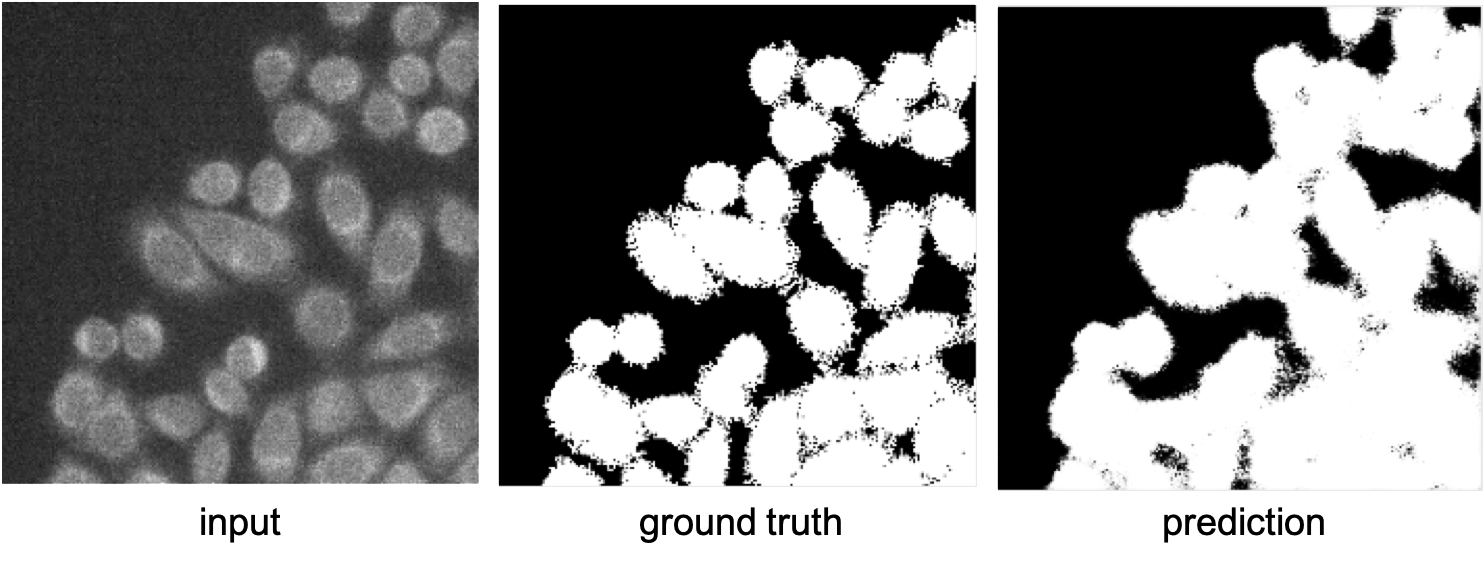

In [26]:
test = load("./images_for_notebook/model_test.png")

With the submission of our final project we provide a small dataset of 10 images to play around with the model and training.